In [43]:
import sklearn
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import re
import pickle

import warnings
warnings.filterwarnings('ignore')

In [44]:
conn = sqlite3.connect('../db.sqlite3')

In [45]:
df_raw = pd.read_sql_query("SELECT * FROM scraper_auto", conn)

In [46]:
df_raw

,id,kenteken,bouwjaar,kilometer_stand,vermogen,is_handgeschakeld,is_benzine,prijs,url,titel,upload_datum,bron,apk,merk,model
0,2197,96-ZKX-1,2012,148283.0,68.0,1.0,1,3750.0,https://www.marktplaats.nl/a/auto-s/peugeot/m1...,Zeer Mooie Peugeot 107 1.0 Access Accent 2012!,2020-06-01 09:20:00,marktplaats,2021-05-14,Peugeot,107
1,2198,79-XKN-1,2012,100472.0,60.0,1.0,1,5950.0,https://www.marktplaats.nl/a/auto-s/volkswagen...,Volkswagen UP! High Up! White 3drs 1e eigenaar...,2020-06-01 20:13:00,marktplaats,2021-02-05,Volkswagen,up!
2,2199,NJ-700-B,2016,97139.0,60.0,1.0,1,8995.0,https://www.marktplaats.nl/a/auto-s/volkswagen...,Volkswagen Polo 1.0 BlueMotion 2016 Zwart APK ...,2020-05-29 08:17:00,marktplaats,2022-05-25,Volkswagen,Polo
3,2200,3-ZBJ-68,2014,137180.0,69.0,1.0,1,6299.0,https://www.marktplaats.nl/a/auto-s/toyota/m15...,Toyota Aygo 1.0 VVT-i x-play NL Auto / Airco /...,2020-05-31 12:33:00,marktplaats,2020-12-29,Toyota,Aygo
4,2201,18-ZLG-2,2011,142000.0,340.0,0.0,1,26900.0,https://www.marktplaats.nl/a/auto-s/audi/m1558...,Audi Quattro RS3 340 pk TOP STAAT leer 5drs au...,2020-06-01 18:30:00,marktplaats,2020-11-18,Quattro,RS3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4157,6354,59-GT-NB,2001,257399.0,98.0,1.0,1,500.0,https://www.marktplaats.nl/a/auto-s/renault/m1...,Renault Clio 1.4-16V 98pk Ludo (bj 2001),2020-05-31 14:51:00,marktplaats,2020-12-16,Renault,Clio
4158,6355,97-ZL-HJ,2008,270000.0,75.0,1.0,1,2300.0,https://www.marktplaats.nl/a/auto-s/renault/m1...,Renault Clio III 1.2 16V 75 pk 3D 2008 Zwart,2020-05-31 14:50:00,marktplaats,2020-12-03,Renault,Clio
4159,6356,H-438-LD,2020,5.0,73.0,1.0,1,12245.0,https://www.marktplaats.nl/a/auto-s/peugeot/m1...,Peugeot 108 1.0 e-VTi Active | Nieuwe auto | V...,2020-05-31 14:48:00,marktplaats,2024-02-28,Peugeot,108
4160,6357,33-LG-LP,2003,223025.0,75.0,1.0,1,1250.0,https://www.marktplaats.nl/a/auto-s/peugeot/m1...,Peugeot 206 1.4 XS,2020-05-31 14:47:00,marktplaats,2021-05-14,Peugeot,206


In [47]:
target_names = ["titel", "bouwjaar", "kilometer_stand", "vermogen", "prijs", "is_handgeschakeld", "is_benzine", "upload_datum", "apk", "merk", "model"]

In [48]:
df = df_raw[target_names].dropna(axis=0)
df['upload_datum'] = pd.to_datetime(df['upload_datum'])
df['apk'] = pd.to_datetime(df['apk'])

average_upload_datum = df['upload_datum'].mean().toordinal()
average_apk =df['apk'].mean().toordinal()

def upload_datum_to_ordinal(date):
    if date is pd.NaT:
        return abs(datetime.now().toordinal() - average_upload_datum)
    else:
        return abs(datetime.now().toordinal() - date.toordinal())
    
def apk_to_ordinal(date):
    if date is pd.NaT:
        return abs(datetime.now().toordinal() - average_apk)
    else:  
        return abs(datetime.now().toordinal() - date.toordinal())

df['upload_datum'] = df['upload_datum'].apply(upload_datum_to_ordinal).astype(int)
df['apk'] = df['apk'].apply(apk_to_ordinal).astype(int)

def parse_titel(titel):
    cleaned = re.sub('[^a-zA-Z]+', ' ', titel.lower())
    stripped = line = re.sub(r'\b\w{1,3}\b', '', cleaned)
    
    return stripped

df['titel'] = df['titel'].apply(parse_titel)

In [49]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [50]:
MIN_PRICE = 1000.
MAX_PRICE = 10000.

df_train = df_train[(df_train['prijs'] > MIN_PRICE) & (df_train['prijs'] < MAX_PRICE)]
df_test = df_test[(df_test['prijs'] > MIN_PRICE) & (df_test['prijs'] < MAX_PRICE)]

df_train

,titel,bouwjaar,kilometer_stand,vermogen,prijs,is_handgeschakeld,is_benzine,upload_datum,apk,merk,model
3403,rover streetwise,2005,123574.0,109.0,1240.0,1.0,1,2,298,Rover,Streetwise
1324,suzuki wagon stand,2004,68813.0,53.0,1950.0,1.0,1,18,285,Suzuki,Wagon
536,suzuki celerio exclusive style blauw,2016,34868.0,68.0,8750.0,1.0,1,2,592,Suzuki,Celerio
2067,mazda limited eigenaar nieuwe automaat airco,2011,58984.0,150.0,9995.0,0.0,1,2,332,Mazda,3
52,mini mini cooper airco,2005,89812.0,90.0,4999.0,1.0,1,20,344,MINI,Mini
...,...,...,...,...,...,...,...,...,...,...,...
2107,opel karl ecoflex edition airco cruise control,2018,59349.0,75.0,6950.0,1.0,1,2,804,Opel,KARL
3997,renault laguna authentique airco clima,2004,183209.0,107.0,1495.0,1.0,1,3,339,Renault,Laguna
1442,opel insignia edition airco trekhaak navi,2010,220591.0,116.0,6495.0,1.0,1,2,89,Opel,Insignia
1677,volkswagen polo,2010,105000.0,86.0,5850.0,1.0,1,2,120,Volkswagen,Polo


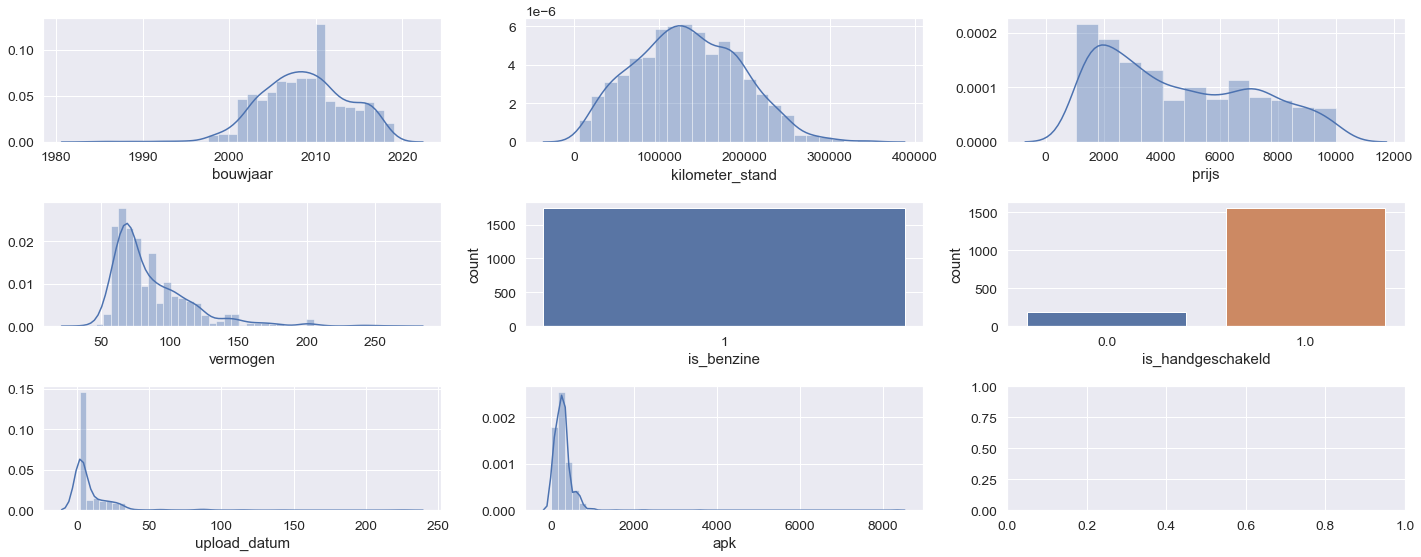

In [51]:
fig, axs = plt.subplots(3, 3, figsize=(20,8))

sns.distplot(df_train['bouwjaar'], ax=axs[0][0]);
sns.distplot(df_train['kilometer_stand'], ax=axs[0][1]);
sns.distplot(df_train['prijs'], ax=axs[0][2]);
sns.distplot(df_train['vermogen'], ax=axs[1][0]);
sns.countplot(df_train['is_benzine'], ax=axs[1][1]);
sns.countplot(df_train['is_handgeschakeld'], ax=axs[1][2]);
sns.distplot(df_train['upload_datum'], ax=axs[2][0]);
sns.distplot(df_train['apk'], ax=axs[2][1]);

plt.tight_layout()

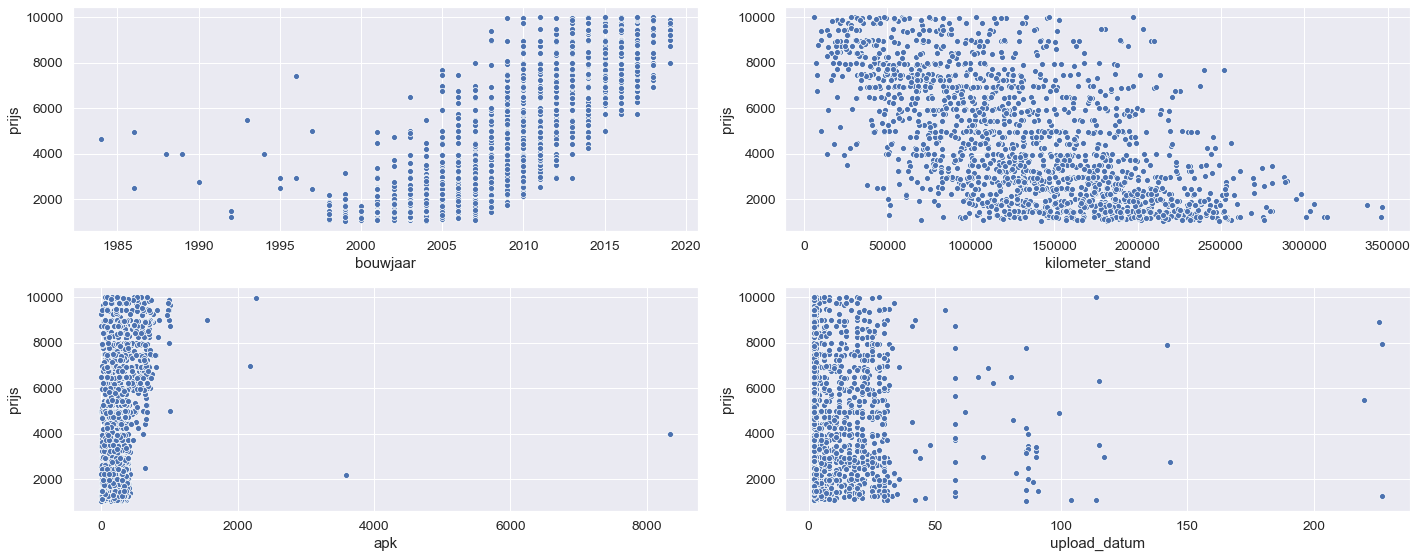

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))

col = 'bouwjaar'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[0][0]);

col = 'kilometer_stand'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[0][1]);

col = 'apk'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[1][0]);

col = 'upload_datum'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[1][1]);

plt.tight_layout()

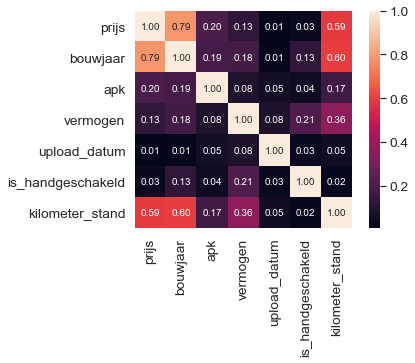

In [53]:
k = 10
corrmat = df_train.corr()
cols = corrmat.nlargest(k, 'prijs')['prijs'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
heatmap = sns.heatmap(np.absolute(cm), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [54]:
df_train.to_pickle("./train_data.pkl")
df_test.to_pickle("./test_data.pkl")